<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# SMS Spam Detector


## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.


## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.


## Imports


In [227]:
# General libraries
import numpy as np
import pandas as pd
from PIL import Image
from collections import Counter

# Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Text processing
import re
import spacy
import en_core_web_sm
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Tensorflow
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from transformers import BertTokenizer, TFBertForSequenceClassification

## Data Preparation


In [3]:
# Loading dataset
file_path = "data/spam.csv"
data = pd.read_csv(file_path, encoding="latin-1")

In [4]:
# Initial dataset overview
print("Dataset Info:\n")
print(data.info())

# Check for missing values
print("\nMissing values:\n")
print(data.isnull().sum())

print("\nFirst 5 rows:\n")
data.head()

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None

Missing values:

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

First 5 rows:



,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Data cleaning


In [5]:
# Combine all relevant columns into the message column
data['message'] = data[['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']].fillna('').agg(' '.join, axis=1)

# Retain only relevant columns and rename them
data = data[['v1', 'message']].rename(columns={'v1': 'label'})

# Convert labels to numerical format
data['label'] = data['label'].map({'ham': 0, 'spam': 1})
data.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
# Check for missing values
print("\nMissing values:\n")
print(data.isnull().sum())


Missing values:

label      0
message    0
dtype: int64


## Data Exploration


### Class Distribution

In [7]:
# Class distribution
class_distribution = data["label"].value_counts()
print("\nClass Distribution:\n")
print(class_distribution)


Class Distribution:

label
0    4825
1     747
Name: count, dtype: int64


In [8]:
# Plot the class distribution
fig = px.bar(
    class_distribution,
    x=class_distribution.index,
    y=class_distribution.values,
    title="Class Distribution",
    labels={"x": "Label", "y": "Count"},
    color=class_distribution.index,
)
fig.show()

### Message Length Distribution

In [9]:
# Adding message length as a feature
data["message_length"] = data["message"].apply(len)
data.head()

,label,message,message_length
0,0,"Go until jurong point, crazy.. Available only ...",114
1,0,Ok lar... Joking wif u oni...,32
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,158
3,0,U dun say so early hor... U c already then say...,52
4,0,"Nah I don't think he goes to usf, he lives aro...",64


In [10]:
# Analyze message length distribution
spam_messages = data[data["label"] == 1]
ham_messages = data[data["label"] == 0]

# Calculate average message lengths
avg_length_spam = spam_messages["message_length"].mean().round(2)
avg_length_ham = ham_messages["message_length"].mean().round(2)

print("\nAverage Message Length:\n")
print(f"Spam: {avg_length_spam} characters")
print(f"Ham: {avg_length_ham} characters")


Average Message Length:

Spam: 142.15 characters
Ham: 74.63 characters


In [11]:
# Plot message length distribution
fig = px.histogram(
    data,
    x="message_length",
    color="label",
    nbins=50,
    title="Message Length Distribution",
    labels={"message_length": "Message Length"},
    barmode="overlay",
    histnorm="density",
)
fig.show()

## Text cleaning

In [12]:
# Loading english core
nlp = en_core_web_sm.load()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'ltgt', '', text)
    text = text.replace("  ", " ").lower().strip()
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS])
    return text

# Apply text cleaning and remove stopwords with spaCy
data['cleaned_message'] = data['message'].apply(clean_text)

In [13]:
data.head()

,label,message,message_length,cleaned_message
0,0,"Go until jurong point, crazy.. Available only ...",114,jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,32,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,158,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,52,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",64,nah I think usf live


In [22]:
# Checking for invalid text
mask = data.cleaned_message.apply(lambda x: type(x) == str)
mask.value_counts()

cleaned_message
True    5572
Name: count, dtype: int64

### Analyze word frequency

In [14]:
# Split words for spam and ham
spam_messages = data[data['label'] == 1]
ham_messages = data[data['label'] == 0]
spam_words = " ".join(spam_messages["cleaned_message"]).split()
ham_words = " ".join(ham_messages["cleaned_message"]).split()

# Get word frequencies
spam_word_freq = Counter(spam_words)
ham_word_freq = Counter(ham_words)

In [15]:
# Top 10 words in spam and ham messages
print("\nTop 10 Words in Spam Messages:\n")
print(spam_word_freq.most_common(10))

print("\nTop 10 Words in Ham Messages:\n")
print(ham_word_freq.most_common(10))


Top 10 Words in Spam Messages:

[('free', 219), ('u', 155), ('txt', 151), ('ur', 144), ('text', 138), ('mobile', 136), ('win', 135), ('stop', 118), ('claim', 115), ('reply', 110)]

Top 10 Words in Ham Messages:

[('I', 3499), ('u', 1003), ('m', 475), ('come', 320), ('s', 312), ('ok', 273), ('know', 258), ('good', 257), ('ur', 246), ('ill', 242)]


In [16]:
# Plotting top 10 words for spam and ham
spam_top_words = pd.DataFrame(
    spam_word_freq.most_common(10), columns=["Word", "Frequency"]
)
ham_top_words = pd.DataFrame(
    ham_word_freq.most_common(10), columns=["Word", "Frequency"]
)

fig = px.bar(
    spam_top_words,
    x="Word",
    y="Frequency",
    title="Top 10 Words in Spam Messages",
    labels={"Word": "Word", "Frequency": "Frequency"},
    color="Frequency",
)
fig.show()

fig = px.bar(
    ham_top_words,
    x="Word",
    y="Frequency",
    title="Top 10 Words in Ham Messages",
    labels={"Word": "Word", "Frequency": "Frequency"},
    color="Frequency",
)
fig.show()

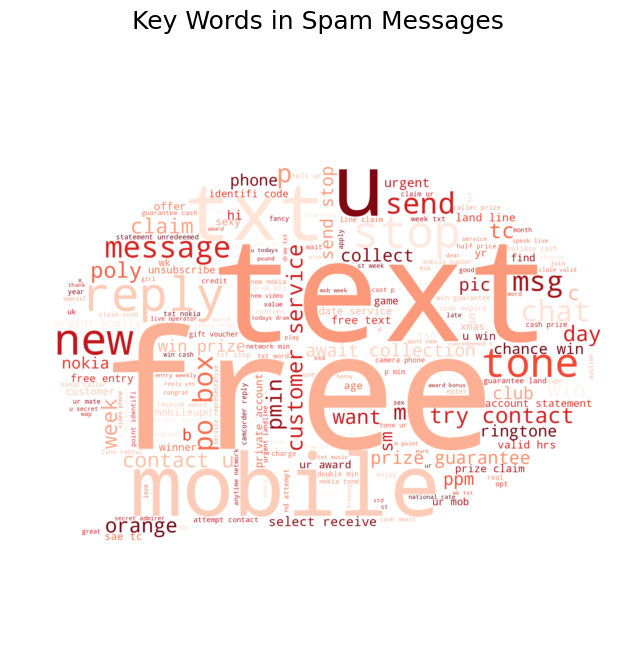

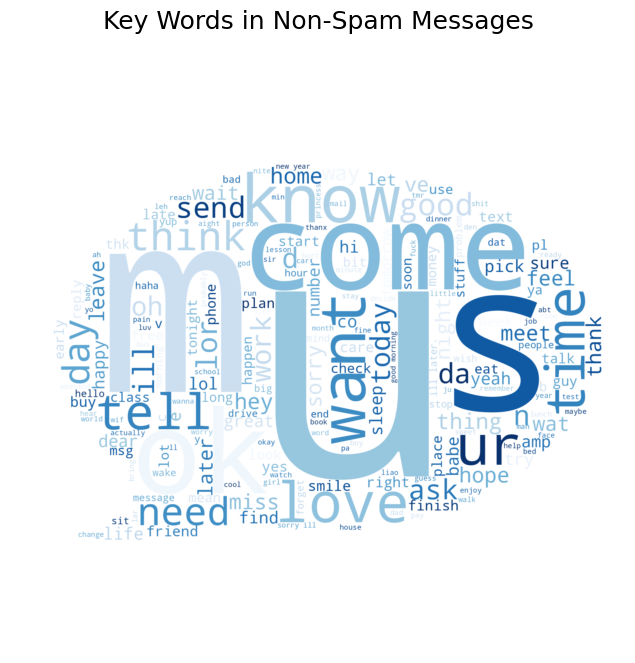

In [17]:
# Loading a custom mask for the WordCloud
mask = np.array(Image.open("img/cloudmask.png"))

# Define the WordCloud for spam messages
spam_wordcloud = WordCloud(
    width=800,
    height=400,
    colormap="Reds",
    background_color="white",
    mask=mask,
).generate(" ".join(spam_words))

# Define the WordCloud for ham messages
ham_wordcloud = WordCloud(
    width=800,
    height=400,
    colormap="Blues",
    background_color="white",
    mask=mask,
).generate(" ".join(ham_words))

# Plotting the spam WordCloud
plt.figure(figsize=(16, 8))
plt.imshow(spam_wordcloud, interpolation="bilinear")
plt.title("Key Words in Spam Messages", fontsize=18)
plt.axis("off")
plt.show()

# Plotting the ham WordCloud
plt.figure(figsize=(16, 8))
plt.imshow(ham_wordcloud, interpolation="bilinear")
plt.title("Key Words in Non-Spam Messages", fontsize=18)
plt.axis("off")
plt.show()

## Text Tokenization

In [36]:
num_words = 1000

# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data["cleaned_message"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(data["cleaned_message"])

# Pad sequences
padded_sequences = pad_sequences(sequences, padding="post")

# Add tokenized sequences to the DataFrame
data["tokenized_message"] = sequences

In [45]:
# Check word frequencies to determine NUM_WORDS
word_counts = tokenizer.word_counts
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Display the most common words and their frequencies
print("\nMost Common Words and Their Frequencies:\n")
for word, count in sorted_word_counts[:20]:
    print(f"{word}: {count}")

# Plot word frequencies for the top 50 words
top_words = pd.DataFrame(sorted_word_counts[:50], columns=['Word', 'Frequency'])
fig = px.bar(top_words, x='Word', y='Frequency', title='Top 50 Word Frequencies', labels={'Word': 'Word', 'Frequency': 'Frequency'})
fig.show()



Most Common Words and Their Frequencies:

i: 3598
u: 1158
m: 511
ur: 390
s: 340
come: 326
know: 284
ok: 278
free: 278
good: 278
send: 268
day: 256
like: 254
want: 245
ill: 243
time: 234
love: 231
text: 215
tell: 208
think: 200


In [37]:
# Inspecting a sample of a tokenized message
print("Original Message:", data['cleaned_message'][0])
print("Tokenized Message:", data['tokenized_message'][0])
print("Padded Sequence:", padded_sequences[0])

Original Message: jurong point crazy available bugis n great world la e buffet cine amore wat
Tokenized Message: [1, 226, 432, 450, 911, 34, 50, 202, 743, 77, 1, 912, 1, 56]
Padded Sequence: [  1 226 432 450 911  34  50 202 743  77   1 912   1  56   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [38]:
data.head()

,label,message,message_length,cleaned_message,tokenized_message
0,0,"Go until jurong point, crazy.. Available only ...",114,jurong point crazy available bugis n great wor...,"[1, 226, 432, 450, 911, 34, 50, 202, 743, 77, ..."
1,0,Ok lar... Joking wif u oni...,32,ok lar joking wif u oni,"[9, 191, 1, 285, 3, 1]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,158,free entry wkly comp win fa cup final tkts st ...,"[10, 295, 513, 636, 31, 1, 744, 413, 1, 125, 1..."
3,0,U dun say so early hor... U c already then say...,52,u dun early hor u c,"[3, 124, 150, 1, 3, 82]"
4,0,"Nah I don't think he goes to usf, he lives aro...",64,nah I think usf live,"[685, 2, 21, 637, 131]"


## Preprocessing

In [55]:
# Train-test split
X = padded_sequences
y = data["label"]

x_temp, x_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=0.2, random_state=42
)

print(f"Dataset size: {len(y_temp) + len(x_test)}")
print(f"Train set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Test set size: {len(x_test)}")

Dataset size: 5572
Train set size: 3565
Validation set size: 892
Test set size: 1115


In [69]:
BATCH_SIZE = 32

# Create TensorFlow Batches
train = Dataset.from_tensor_slices((x_train, y_train))
val = Dataset.from_tensor_slices((x_val, y_val))

train_batch = train.shuffle(len(x_train)).batch(BATCH_SIZE)
val_batch = val.shuffle(len(x_val)).batch(BATCH_SIZE)

In [159]:
# Visualize a sample batch
for text, label in train_batch.take(1):
    print(text, label)

tf.Tensor(
[[  1   1   1 ...   0   0   0]
 [266   2 106 ...   0   0   0]
 [390   2 296 ...   0   0   0]
 ...
 [ 78   2  22 ...   0   0   0]
 [623   1 151 ...   0   0   0]
 [  1   1   1 ...   0   0   0]], shape=(32, 71), dtype=int32) tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(32,), dtype=int64)


## Deep Learning model training

### Word Embedding

In [174]:
vocab_size = tokenizer.num_words
embedding_dim = 128

model_embed = Sequential(
    [
        Input(shape=(text.shape[1],)),
        Embedding(vocab_size + 2, embedding_dim, name="embedding"),
        GlobalAveragePooling1D(),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

In [175]:
model_embed.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 71, 128)        │       128,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,089 (598.00 KB)

 Trainable params: 153,089 (598.00 KB)

 Non-trainable params: 0 (0.00 B)

In [176]:
metrics = [
    BinaryAccuracy(name="accuracy"),
    Precision(name="precision"),
    Recall(name="recall"),
]

model_embed.compile(optimizer="adam", loss="binary_crossentropy", metrics=metrics)

In [177]:
class_counts = data["label"].value_counts()
class_counts

label
0    4825
1     747
Name: count, dtype: int64

In [178]:
total_samples = len(data)
num_classes = 2

class_weights = {}
for clss, count in class_counts.items():
    weight = (1 / count) * total_samples / num_classes
    class_weights[clss] = weight

class_weights

{0: 0.5774093264248704, 1: 3.72958500669344}

In [185]:
history = model_embed.fit(
    train_batch, epochs=20, validation_data=val_batch, class_weight=class_weights
)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9842 - loss: 0.0430 - precision: 0.9113 - recall: 0.9876 - val_accuracy: 0.9798 - val_loss: 0.0852 - val_precision: 0.9762 - val_recall: 0.8367
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9894 - loss: 0.0324 - precision: 0.9412 - recall: 0.9869 - val_accuracy: 0.9159 - val_loss: 0.2201 - val_precision: 0.5706 - val_recall: 0.9490
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9882 - loss: 0.0338 - precision: 0.9194 - recall: 0.9906 - val_accuracy: 0.9563 - val_loss: 0.1537 - val_precision: 0.7398 - val_recall: 0.9286
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9876 - loss: 0.0322 - precision: 0.9278 - recall: 0.9884 - val_accuracy: 0.9675 - val_loss: 0.0878 - val_precision: 0.8416 - val_recall: 0.8673
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9908 - loss: 0.0268 - precision: 0.9479 - recall: 0.9911 - val_accuracy: 0.9787 - val_loss: 0.

In [180]:
model_embed.save("./models/model_wordembed.keras")

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


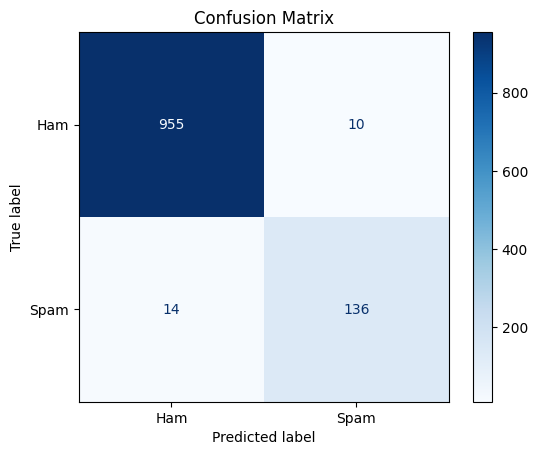

In [181]:
# Evaluate the Model
y_pred = (model_embed.predict(x_test) > 0.5).astype("int")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [189]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       965
           1       0.93      0.91      0.92       150

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



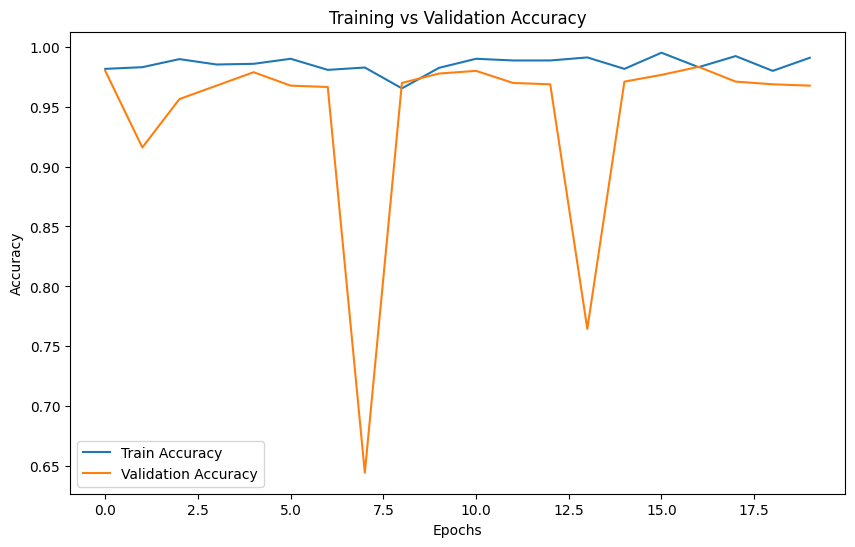

In [190]:
# Plot Training History
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

### Test with your own SMS !

In [212]:
example_sms = {
    "spam1": "Congratulations! You've won a $1,000 Walmart gift card. Go to http://bit.ly/123456 to claim now.",
    "ham1": "Hey, what time are we meeting tomorrow?",
    "spam2": "Get a free iPhone by clicking on the link below!",
    "ham2": "Don't forget to bring your umbrella tomorrow.",
    "spam3": "URGENT! You have won a 1 week FREE membership. Call 09061701461 now!",
    "ham3": "Can you send me the notes from today's meeting?"
}

In [216]:
def predict_sms(sms_text, model, tokenizer, maxlen=100):
    """Predict if an SMS is spam or not"""
    # Preprocess the SMS
    sms_cleaned = clean_text(sms_text)

    # Tokenize and pad the SMS
    sms_sequence = tokenizer.texts_to_sequences([sms_cleaned])
    sms_padded = pad_sequences(
        sms_sequence, maxlen=maxlen, padding="post", truncating="post"
    )

    # Predict using the model
    prediction = model.predict(sms_padded)
    label = "Spam" if prediction[0] > 0.5 else "Non-Spam"

    return label, prediction[0][0] * 100

In [218]:
MODEL = model_embed

for key, sms in example_sms.items():
    label, confidence = predict_sms(sms, MODEL, tokenizer)
    print(f"Example: {key}\nSMS: {sms}\nPredicted Label: {label}\nProbability of spam: {confidence:.2f}%\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Example: spam1
SMS: Congratulations! You've won a $1,000 Walmart gift card. Go to http://bit.ly/123456 to claim now.
Predicted Label: Spam
Probability of spam: 62.05%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Example: ham1
SMS: Hey, what time are we meeting tomorrow?
Predicted Label: Non-Spam
Probability of spam: 0.07%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Example: spam2
SMS: Get a free iPhone by clicking on the link below!
Predicted Label: Spam
Probability of spam: 78.63%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Example: ham2
SMS: Don't forget to bring your umbrella tomorrow.
Predicted Label: Non-Spam
Probability of spam: 1.91%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Example: spam3
SMS: URGENT! You have won a 1 week FREE membership. Call 09061701461 now!
Predicted Label: Spam
Probability of spam: 98.38%

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Example: ham3
SMS: Can you send me the notes from today's meeting?
Predicted Label: Non-Spam
Probability of spam

# WIP Transfer Learning

### Transfer Learning

In [225]:
X = data['message'].values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [226]:
# Load pre-trained BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize and encode sequences in the dataset
def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Encode the training, validation, and test sets
train_encodings = encode_texts(data['cleaned_message'].iloc[y_train.index], bert_tokenizer)
val_encodings = encode_texts(data['cleaned_message'].iloc[y_val.index], bert_tokenizer)
test_encodings = encode_texts(data['cleaned_message'].iloc[y_test.index], bert_tokenizer)

# Convert labels to tensors
train_labels = tf.convert_to_tensor(y_train.values)
val_labels = tf.convert_to_tensor(y_val.values)
test_labels = tf.convert_to_tensor(y_test.values)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(len(x_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(BATCH_SIZE)

# Compile the BERT model
bert_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=metrics)

# Train the BERT model
bert_history = bert_model.fit(
    train_dataset,
    epochs=3,
    validation_data=val_dataset,
    class_weight=class_weights
)

# Save the fine-tuned BERT model
bert_model.save('./models/bert_model')

# Evaluate the BERT model
bert_loss, bert_accuracy = bert_model.evaluate(test_dataset)
print(f'BERT Model Accuracy: {bert_accuracy * 100:.2f}%')

# Predict using the BERT model
def predict_sms_bert(sms_text, model, tokenizer, max_length=128):
    """Predict if an SMS is spam or not using BERT"""
    # Preprocess the SMS
    sms_cleaned = clean_text(sms_text)

    # Tokenize and encode the SMS
    sms_encoding = tokenizer(
        [sms_cleaned],
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    # Predict using the model
    prediction = model.predict(dict(sms_encoding))
    label = "Spam" if tf.argmax(prediction.logits, axis=1).numpy()[0] == 1 else "Non-Spam"

    return label, tf.nn.softmax(prediction.logits, axis=1).numpy()[0][1] * 100

# Test the BERT model with example SMS
for key, sms in example_sms.items():
    label, confidence = predict_sms_bert(sms, bert_model, bert_tokenizer)
    print(f"Example: {key}\nSMS: {sms}\nPredicted Label: {label}\nProbability of spam: {confidence:.2f}%\n")

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AttributeError: 'Variable' object has no attribute '_distribute_strategy'